In [150]:
import numpy as np
import pandas as pd
import catboost as cb
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV  #调参模块

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [3]:
data = pd.read_csv("C:\\Users\\p'c\\data1.csv", encoding = 'ISO-8859-1', engine = 'python')  # 部分清洗过和转换过变量的数据集。

In [4]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_2ership,annual_inc,...,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,disbursement_method,debt_settlement_flag,target
0,10000,10000,10000.0,0,0.1033,324.23,1,0,0,280000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,2500,2500,2500.0,0,0.1356,84.92,2,10,1,55000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
2,12000,12000,12000.0,1,0.1356,276.49,2,0,0,40000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
3,15000,15000,14975.0,1,0.1447,352.69,2,11,0,30000.0,...,48.8,0.0,15.0,0.0,0.0,NaN,0,1,0,0
4,16000,16000,16000.0,1,0.1797,406.04,3,5,0,51000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0


In [5]:
#计算缺失率

def compute_missing_ratio(df):
    dict_columns = {}
    column_name = [i for i in df.columns]
    for i in column_name:
        missing_rate = (df.shape[0]-df[i].count())*1.0/len(df.index) #计算缺失率
        dict_columns[i] = missing_rate
    return dict_columns

In [6]:
#删除缺失值大于一定比例的列，约等效于df.dropna(axis=1, thresh = int(0.8*len(df)))
#删除行部分，等效于df.dropna(axis = 0, subset = ['col'])

def delete_missing(df, missing_ratio, thresh_loss_ratio):
    key_for_dropped = []
    for key in missing_ratio.keys():
        if missing_ratio[key] > thresh_loss_ratio:
            key_for_dropped.append(key)
    
    print(len(key_for_dropped))
    df2 = df.drop(key_for_dropped, axis = 1, inplace = False)
    #column_name = [i for i in df.columns][0]
    #index_missing = [int(i) for i in df[column_name].index[np.where(np.isnan(df[column_name]))[0]].tolist()]
    #是否繁琐？np.where(...).tolist()即获得有空缺的索引
    #for i in index_missing:
        #df.drop(index = i, axis=0, inplace = True)
    return df2

In [7]:
#删除含有太多相同数据的列，以及太过分散，不利于决策树分裂节点的列（例如emp_title，列值太过分散）
def delete_asymmetrical(df, asym_degree, noise_degree):
    key_for_dropped = []
    for key in df.columns:
        temp = df[key].value_counts()/len(df[key])  # 输出的是每个值和每个值出现的频率
        if (np.max(temp) < asym_degree) or (np.max(temp) > noise_degree):
            key_for_dropped.append(key)

    #print(key_for_dropped)
    df2 = df.drop(key_for_dropped, axis = 1, inplace = False)
    return df2

In [8]:
miss_rate = compute_missing_ratio(data)
miss_rate.keys()

dict_keys(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'home_2ership', 'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'title', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc

In [9]:
miss_rate # 一个字典类型，里面是所有变量的缺失率

{'loan_amnt': 0.0,
 'funded_amnt': 0.0,
 'funded_amnt_inv': 0.0,
 'term': 0.0,
 'int_rate': 0.0,
 'installment': 0.0,
 'grade': 0.0,
 'emp_length': 0.0,
 'home_2ership': 0.0,
 'annual_inc': 0.0,
 'verification_status': 0.0,
 'pymnt_plan': 0.0,
 'purpose': 0.0,
 'title': 0.0,
 'dti': 0.0018456219044949071,
 'delinq_2yrs': 0.0,
 'inq_last_6mths': 0.0,
 'mths_since_last_delinq': 0.5622215992274865,
 'mths_since_last_record': 0.8796841416690029,
 'open_acc': 0.0,
 'pub_rec': 0.0,
 'revol_bal': 0.0,
 'revol_util': 0.0012148397346042426,
 'total_acc': 0.0,
 'initial_list_status': 0.0,
 'out_prncp': 0.0,
 'out_prncp_inv': 0.0,
 'total_pymnt': 0.0,
 'total_pymnt_inv': 0.0,
 'total_rec_prncp': 0.0,
 'total_rec_int': 0.0,
 'total_rec_late_fee': 0.0,
 'recoveries': 0.0,
 'collection_recovery_fee': 0.0,
 'last_pymnt_amnt': 0.0,
 'collections_12_mths_ex_med': 0.0,
 'mths_since_last_major_derog': 0.7727626701554372,
 'policy_code': 0.0,
 'application_type': 0.0,
 'annual_inc_joint': 0.86931127931968

In [10]:
loan_data = data
loan_data_2 = delete_missing(loan_data, miss_rate, 0.8)
cleaned_data = delete_asymmetrical(loan_data_2, 0.001, 0.999)  # 有些列常理上是不能丢的，比如installment。这里被迫取了非常保守的阈值，事后应该也会有一些被模型本身舍弃掉。
cleaned_data.shape

15


(128412, 83)

In [11]:
# 虽然决策树模型，特别是catboost对于NAN的容忍度是非常高的，但逻辑回归和XGBoost对NAN的容忍度比较低，特别是逻辑回归不能用于含有NAN的数据集上。故这里简单用imputer来补全缺失值。

from sklearn.impute import SimpleImputer

imp_mf = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
impdata = imp_mf.fit_transform(cleaned_data)
impdf = pd.DataFrame(impdata, columns=cleaned_data.columns)
fdata = impdf.astype({'target': 'int64'}, copy=True)
fdata

d:\Anaconda3\lib\site-packages\sklearn\impute\_base.py:49: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode = stats.mode(array)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_2ership,annual_inc,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,target
0,10000.0,10000.0,10000.0,0.0,0.1033,324.23,1.0,0.0,0.0,280000.0,...,0.0,4.0,91.3,28.6,0.0,61364.0,20900.0,54912.0,0.0,0
1,2500.0,2500.0,2500.0,0.0,0.1356,84.92,2.0,10.0,1.0,55000.0,...,0.0,3.0,100.0,0.0,1.0,16901.0,36500.0,18124.0,1.0,0
2,12000.0,12000.0,12000.0,1.0,0.1356,276.49,2.0,0.0,0.0,40000.0,...,0.0,3.0,100.0,60.0,0.0,32462.0,36800.0,9000.0,1.0,0
3,15000.0,15000.0,14975.0,1.0,0.1447,352.69,2.0,11.0,0.0,30000.0,...,0.0,1.0,100.0,50.0,0.0,24507.0,9900.0,14490.0,1.0,0
4,16000.0,16000.0,16000.0,1.0,0.1797,406.04,3.0,5.0,0.0,51000.0,...,0.0,3.0,77.8,0.0,0.0,39339.0,29500.0,38424.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128407,23000.0,23000.0,23000.0,0.0,0.1502,797.53,2.0,10.0,0.0,75000.0,...,0.0,7.0,96.4,14.3,0.0,40614.0,47100.0,21000.0,1.0,1
128408,10000.0,10000.0,10000.0,0.0,0.1502,346.76,2.0,5.0,0.0,38000.0,...,0.0,1.0,73.3,40.0,0.0,9323.0,9100.0,2000.0,1.0,0
128409,5000.0,5000.0,5000.0,0.0,0.1356,169.83,2.0,10.0,0.0,35360.0,...,0.0,3.0,92.9,50.0,0.0,4976.0,3000.0,6028.0,1.0,0
128410,10000.0,10000.0,9750.0,0.0,0.1106,327.68,1.0,11.0,1.0,44400.0,...,0.0,3.0,92.0,0.0,0.0,16440.0,20500.0,10171.0,1.0,0


In [40]:
# 变量分箱：用IV值再筛选一次变量。
# IV的计算需要用到分箱。这里存在等频、等深、kmeans、决策树、卡方等分箱方法。需实验哪一种分箱能带来较高的IV值。
# 后续会补充几种分箱的手写函数，这里简单用toad

import toad

iv_list = toad.quality(fdata, 'target', iv_only=True)  #高维度数据，计算gini和信息熵的耗时太长
columns_to_drop = iv_list[iv_list['iv'] <= 0.02].index # iv大于等于0.02，变量具有弱预测能力。小于0.02表示几乎无预测能力。但也不一定，有些变量或许还可以留下（例如term）
iv_columns = iv_list[iv_list['iv'] > 0.02].index.tolist()
iv_columns.append('target')
fdata_iv = fdata[iv_columns]
fdata_iv

,total_rec_prncp,total_pymnt_inv,total_pymnt,last_pymnt_amnt,total_rec_int,int_rate,grade,total_rec_late_fee,out_prncp,mths_since_recent_inq,...,open_rv_12m,mths_since_recent_bc,mths_since_last_major_derog,mo_sin_rcnt_rev_tl_op,mths_since_recent_revol_delinq,total_acc,num_rev_tl_bal_gt_0,num_op_rev_tl,open_acc_6m,target
0,478.34,639.85,639.85,324.23,161.51,0.1033,1.0,0.0,9521.66,11.0,...,1.0,11.0,45.0,11.0,21.0,23.0,4.0,9.0,1.0,0
1,113.98,167.02,167.02,84.92,53.04,0.1356,2.0,0.0,2386.02,2.0,...,2.0,1.0,45.0,1.0,21.0,34.0,5.0,7.0,2.0,0
2,283.37,539.42,539.42,276.49,256.05,0.1356,2.0,0.0,11716.63,4.0,...,2.0,10.0,45.0,9.0,21.0,9.0,6.0,7.0,1.0,0
3,345.43,686.14,687.29,352.69,341.86,0.1447,2.0,0.0,14654.57,1.0,...,1.0,31.0,45.0,6.0,21.0,30.0,13.0,18.0,1.0,0
4,335.37,788.12,788.12,406.04,452.75,0.1797,3.0,0.0,15664.63,4.0,...,1.0,6.0,52.0,6.0,52.0,27.0,2.0,3.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128407,1025.67,1547.08,1547.08,797.53,521.41,0.1502,2.0,0.0,0.00,4.0,...,4.0,5.0,45.0,4.0,22.0,28.0,5.0,9.0,4.0,1
128408,1136.05,1725.46,1725.46,346.76,589.41,0.1502,2.0,0.0,8863.95,17.0,...,1.0,11.0,45.0,11.0,6.0,16.0,5.0,8.0,0.0,0
128409,579.60,845.38,845.38,169.83,265.78,0.1356,2.0,0.0,4420.40,9.0,...,3.0,10.0,45.0,9.0,21.0,15.0,3.0,6.0,0.0,0
128410,1199.47,1582.46,1623.04,327.68,423.57,0.1106,1.0,0.0,8800.53,1.0,...,2.0,1.0,53.0,1.0,40.0,25.0,4.0,14.0,3.0,0


In [41]:
# 一个更高效的筛选方法
# toad.selection.select(dataframe, target='target', empty=0.9, iv=0.02, corr=0.7, return_drop=False, exclude=None)
# 筛掉缺失率高于0.9，IV小于0.02，相关系数高于0.7的变量

In [165]:
# 考虑到逻辑回归有无法收敛的风险，单独做一个归一化的数据集。

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

logit_scalar = MinMaxScaler()  # 是否不能用standardscalar，因变量不一定服从正态分布？
fdata_logit = fdata_iv.drop(columns='target', inplace=False)
ldata0 = logit_scalar.fit_transform(fdata_logit)
ldata1 = pd.DataFrame(ldata0, columns=fdata_logit.columns)
target_data = pd.DataFrame({'target': fdata_iv['target']})
ldata = pd.concat([ldata1, target_data], axis=1)

### 事前准备（二）：模型评估指数
##### 混淆矩阵分数、accuracy sore, ROC、AUC、f1_score、KS、Gini、PSI、Lift提升度、logloss

In [43]:
### 计算KS值 for Kolmogorov-Smirnoff test
### K-S图反映了模型预测的坏客户和好客户在样本中的分离程度，横坐标是模型预测概率（分数），纵坐标是已预测出的好/坏客户占好坏客户总数的比例。所以它们都会趋向1.
### 因此，K-S图由两条线构成：累计预测为好客户的比例，累计预测为坏客户的比例。K-S值是这两条线垂直方向上距离的最大值。KS值越大，这两条线分得越开，说明模型区分能力越好。

### 例如，好客户线非常贴近左上角，坏客户线非常贴近右下角，意味着预测概率低的都被预测为好客户，预测概率高的都被预测为坏客户，模型这时候区分能力很强。
### 反之，如果模型接近随机预测，好坏客户的预测会混在一起，此时两条线会黏得很紧。

### 注意，K-S模型只反映分割能力，不反映分割正确性。上述例子如果反过来，模型和真实结果的预测刚好反过来，那么K-S值也很高。所以单看KS值不够，还要看AUC。


def KS(df, thescore, target):
    '''
    :param df: 包含目标变量与预测值的数据集
    :param score: 得分或概率
    :param target: 目标变量
    :return: KS值
    '''
    #根据score分数和目标变量，计算每个score总共有几个客户
    total = df.groupby([thescore])[target].count()
    #计算每个分数下预测出了几个坏客户
    bad = df.groupby([thescore])[target].sum()
    all = pd.DataFrame({'total':total, 'bad':bad})
    all['good'] = all['total'] - all['bad']
    all[thescore] = all.index
    all.index = range(len(all))
    all = all.sort_values(by = thescore, ascending = True)

    #坏客户总数
    num_bad = all['bad'].sum()

    #好客户总数
    num_good = all['good'].sum()

    #累计坏客户概率
    all['badCumRate'] = all['bad'].cumsum()/num_bad

    #累计好客户概率
    all['goodCumRate'] = all['good'].cumsum()/num_good

    #坏客户-好客户概率的序列
    ks_array = all.apply(lambda x: abs(x.badCumRate - x.goodCumRate), axis = 1)
    
    #最大值就是ks值。
    ks = max(ks_array)
    return ks

In [44]:
### AUC代表ROC曲线下的面积，表示模型正确分类阳性样本的能力。最理想的模型，AUC=1；最糟糕的模型（随机分类），AUC=0.5。
### 首先，ROC曲线的横坐标是FPR，即假阳率；纵坐标是TPR，即真阳率。ROC曲线上的每一个样本点对应一个预测概率（分数），通过让每一个分数都成为分类器的阈值，我们可以得出每一个阈值的TPR和FPR，进而绘制ROC曲线。
### ROC曲线越“方”越好，这意味着TPR始终显著高于FPR，模型正确分类阳性样本的能力始终很强；但ROC曲线有时会交叉，这种时候只能通过AUC比较。
### AUC相当于对TPR求和，同样也是越大越好。
# 注意，如果模型预测结果和真实结果恰好是相反的，那么这时AUC会非常小：此时应用1-AUC表示其分类能力，意为把模型结果反过来用。

def AUC(y_true, y_scores):
    auc_value = 0
    #通过TPR, FPR计算AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores, pos_label = 1)
    auc_value = auc(fpr, tpr)
    if auc_value < 0.5:
        auc_value = 1 - auc_value
    return auc_value

### 定义上，Gini系数衡量坏账户数在好账户数上的累积分布与随机分布曲线之间的面积，也反映模型区分样本能力的强弱，看上去和K-S比较像。但是，gini和ROC讲的几乎是同一件事。
# 如果一个分类器按照预测分数排序，总是能先分类出绝大多数好客户，再分类出绝大多数坏客户，那么对应的Gini曲线刚好就是ROC按对角线翻转过来的样子，虽然两者坐标不一样。这就是为什么gini可以用AUC近似。
# gini = A+0.5, gini+1 = (A+0.5)/0.5 = AUC/0.5 = 2*AUC, gini = 2*AUC - 1

def Gini(auc):
    gini = 2*auc - 1
    return gini

def Draw_roc(auc_value, y_test, pos_prob_list):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_prob_list, pos_label = 1)
    #画对角线
    plt.plot([0, 1], [0, 1], '--', color = (0.6, 0.6, 0.6), label = 'Diagonal Line')
    plt.plot(fpr, tpr, label = 'ROC curve (area = %0.2f)' % auc_value)
    plt.title('ROC curve')
    plt.legend(loc = 'lower right')

In [73]:
### Lift指数：反映使用模型比不使用模型的提高程度
### 计算方法：按预测概率从大到小排序，等频率分箱，计算每个分箱内 坏样本/总坏样本 / 分箱样本/总样本 的比例。Lift曲线的第一个值是Lift值。
### df的格式：score和target = predicted_label

def lift_curve(df, thescore, target, box_num):
    df_sorted = df.sort_values(by='score', ascending=False)
    df_sorted['box_label'] = df_sorted['score']
    box_step = int(df_sorted.shape[0]/box_num)
    for i in range(box_num):
        if(i<box_num-1):
            df_sorted.iloc[(box_step*i):(box_step*(i+1)), 2] = i+1
        else:
            df_sorted.iloc[(box_step*i): , 2] = i+1
    total = df_sorted.groupby(['box_label'])['target'].count()
    bad = df_sorted.groupby(['box_label'])['target'].sum()
    all = pd.DataFrame({'total':total, 'bad':bad})
    all['total%'] = all['total']/len(df_sorted)
    all['bad%'] = all['bad']/sum(df_sorted['target'])
    all['cumtotal%'] = all['total%'].cumsum()
    all['cumbad%'] = all['bad%'].cumsum()
    all['lift'] = all['cumbad%']/all['cumtotal%']  # lift表，含lift值（第一个）和lift曲线的数据

    lift_value = all.iloc[0, -1] # lift值

    # 绘制lift曲线

    all['base'] = np.ones(len(all))

    plt.figure(figsize=[8,4])
    plt.plot(pd.Series(all.index), all['base'],  marker = 'o', linewidth=1, markersize=2)
    plt.plot(pd.Series(all.index), all['lift'],  marker = 'o', linewidth=1, markersize=2)
    plt.title('Lift curve')
    plt.show()
     
    return(lift_value)

In [46]:
### PSI 模型稳定性指标
### 函数输入：x_it, y_it(expect), x_oot, y_oot(actual)。用时间内样本的预测分数和时间外样本的预测分数进行分箱，统计分箱内样本数量分布的差异
### PSI分模型稳定性和特征稳定性。操作方法类似，都是对目标值进行等分，算出每个区间的值的比例，然后求PSI。但在特征稳定性测试中，PSI<0.0001时，特征的取值稳定。

def predict_scores(y, x, model):
    prob_list = model.predict_proba(x)
    pos_prob_list = [i[1] for i in prob_list]
    pos_prob_list.sort()
    pos_prob_list_box = [round(i, 2) for i in pos_prob_list]
    predicted_scores = pd.DataFrame({'pred_prob_box': pos_prob_list_box})
    prob_dist = predicted_scores['pred_prob_box'].value_counts()
    prob_dist = pd.DataFrame({'prob_count': prob_dist})
    #print(prob_dist)
    
    # 有一些概率分数是没有样本的，缺失值会导致时间内/时间外样本的概率分布不等长，需补齐。
    prob_interval = np.arange(0, 1.01, 0.01)
    for i in list(set([round(i, 2) for i in prob_interval]) - set(prob_dist.index)):  # 消除浮点数误差，并把set类型转换为list类型，否则无法索引
        temp_df = pd.DataFrame({'prob_count': 0}, index=[i])
        prob_dist = pd.concat([prob_dist, temp_df])
    
    prob_dist = prob_dist.sort_index(ascending=True)

    prob_dist['prob_count%'] = prob_dist['prob_count']/sum(prob_dist['prob_count'])
    return(prob_dist)


def calc_PSI(x_it, y_it, x_oot, y_oot, model):

    it_score = predict_scores(y_it, x_it)  # 时间内样本预测概率分布
    oot_score = predict_scores(y_oot, x_oot) # 时间外样本预测概率分布

    psi = 0
    if len(it_score)!=len(oot_score):
        print('Samples fail to match')
    else:
        num = len(it_score)
        for i in range(num):
            value = (oot_score.iloc[i, -1] - it_score.iloc[i, -1])*math.log((oot_score.iloc[i, -1]/it_score.iloc[i, -1]), math.e)
            psi += value
    return psi

In [74]:
# 整合一个模型指标输出函数

def model_eval(df, thescore, target, box_num, y_true, y_pred, pos_prob_list):
    # summarize K-S value
    ks = KS(df, thescore, target)

    # summarize ROC/AUC/Gini
    auc = AUC(y_true, pos_prob_list)
    gini = Gini(auc)

    Draw_roc(auc, y_true, pos_prob_list)

    # summarize lift value
    lift = lift_curve(df, thescore, target, box_num)

    # summarize confusion matrix(precision, recall, accuracy, f1 score)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    model_eval_matrix = pd.DataFrame({'precision':precision, 'recall':recall, 'accuracy':accuracy, 'f1_score':f1, 'KS_value':ks, 'AUC':auc, 'Gini':gini, 'Lift':lift}, index=[0])
    return(model_eval_matrix)

In [48]:
# 模型分

#print('accuracy on the train subset:{:.4f}'.format(model.score(train_x, y_train)))
#print('accuracy on the test subset:{:.4f}'.format(model.score(test_x, y_test)))

### 第一部分：使用逻辑回归对数据建模

In [49]:
from sklearn.linear_model import LogisticRegression

In [166]:
Y = ldata['target']
X = ldata.iloc[:,:-1]

In [167]:
#分开训练集和测试集
train_x, test_x, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 0)

In [168]:
clf = LogisticRegression(max_iter=5000)

clf.fit(train_x, y_train)

LogisticRegression(max_iter=5000)

In [169]:
y_pred = clf.predict(test_x)
y_true = y_test

#获取所有x数据的坏客户预测概率
prob_list = clf.predict_proba(test_x)
pos_prob_list = [i[1] for i in prob_list]

clf_df = pd.DataFrame({'score': pos_prob_list, 'target': y_test}) #合成一个数据集，内含预测概率，还有分类器给的值。用于计算ks, lift等指标。

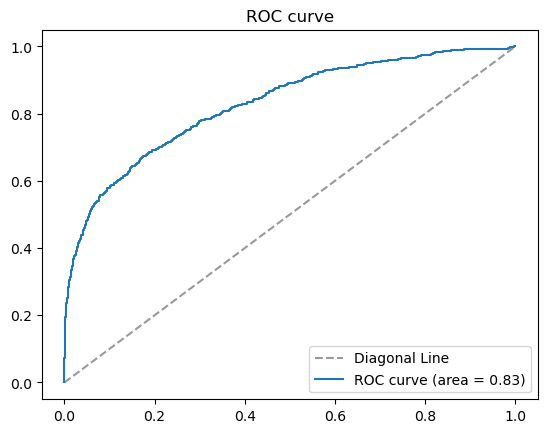

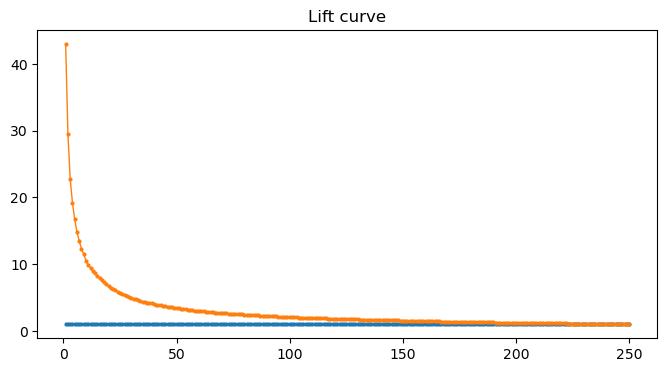

In [170]:
clf_eval = model_eval(clf_df, 'score', 'target', box_num=250, y_true=y_true, y_pred=y_pred, pos_prob_list=pos_prob_list)

In [171]:
clf_eval

,precision,recall,accuracy,f1_score,KS_value,AUC,Gini,Lift
0,0.928571,0.049057,0.986865,0.09319,0.50011,0.828401,0.656803,42.951286


##### 这一次训练的结果是查全率过于低，其它指标相对良好。逻辑回归的参数调优可能需要围绕着正则化和solver的取值进行，也可能需要进行过采样，比如SMOTE采样，来缓解positive sample的匮乏程度。

### 第二部分：使用XGBoost, LightGBM, Catboost进行分类建模

In [78]:
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

import catboost as cb
import lightgbm as lgb

xgb1 = XGBClassifier()
lgb1 = lgb.LGBMClassifier()
cb1 = cb.CatBoostClassifier()

In [113]:
# 决策树不需要对变量归一化。这里仍用归一化前的数据

Yf = fdata_iv['target']
Xf = fdata_iv.iloc[:,:-1]

#分开训练集和测试集
train_x, test_x, y_train, y_test = train_test_split(Xf, Yf, test_size=0.3, random_state = 0)

In [82]:
# XGBoost分类器

xgb1.fit(train_x, y_train, verbose=0)

d:\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
d:\Anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:27:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [91]:
# XGBoost分类器（续）

xgb_y_pred = xgb1.predict(test_x)
xgb_y_true = y_test

#获取所有x数据的坏客户预测概率
prob_list_xgb = xgb1.predict_proba(test_x)
pos_prob_list_xgb = [i[1] for i in prob_list_xgb]

xgb_df = pd.DataFrame({'score': pos_prob_list_xgb, 'target': y_test}) #合成一个数据集，内含预测概率，还有分类器给的值。用于计算ks, lift等指标。

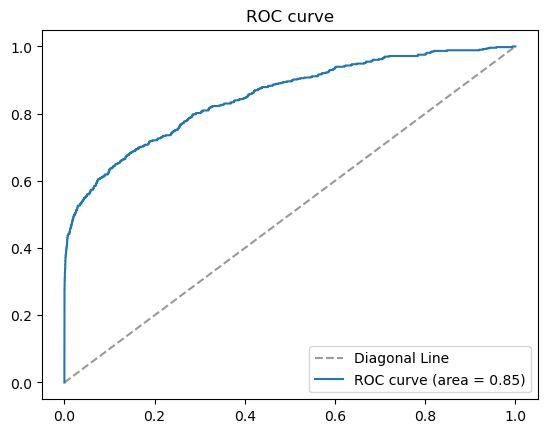

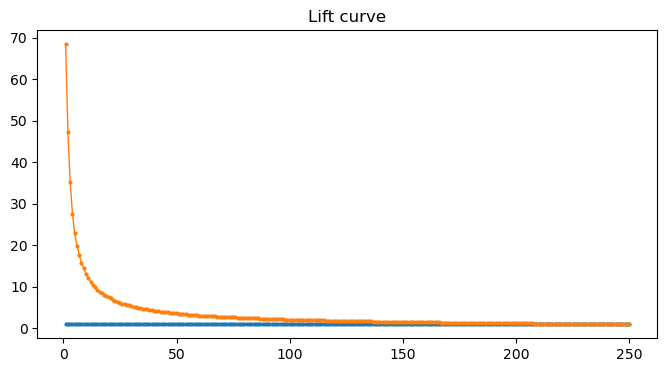

In [92]:
xgb_eval = model_eval(xgb_df, 'score', 'target', box_num=250, y_true=xgb_y_true, y_pred=xgb_y_pred, pos_prob_list=pos_prob_list_xgb)

In [93]:
xgb_eval

,precision,recall,accuracy,f1_score,KS_value,AUC,Gini,Lift
0,0.87027,0.303774,0.989799,0.45035,0.538101,0.850162,0.700325,68.438863


##### 粗看之下，XGBoost的precision略高于逻辑回归，recall显著高于逻辑回归，但分数仍然不高。

In [87]:
# LightGBM分类器

lgb1.fit(train_x, y_train, verbose=0)

LGBMClassifier()

In [94]:
# LightGBM分类器（续）

lgb_y_pred = lgb1.predict(test_x)
lgb_y_true = y_test

#获取所有x数据的坏客户预测概率
prob_list_lgb = lgb1.predict_proba(test_x)
pos_prob_list_lgb = [i[1] for i in prob_list_lgb]

lgb_df = pd.DataFrame({'score': pos_prob_list_lgb, 'target': y_test}) #合成一个数据集，内含预测概率，还有分类器给的值。用于计算ks, lift等指标。

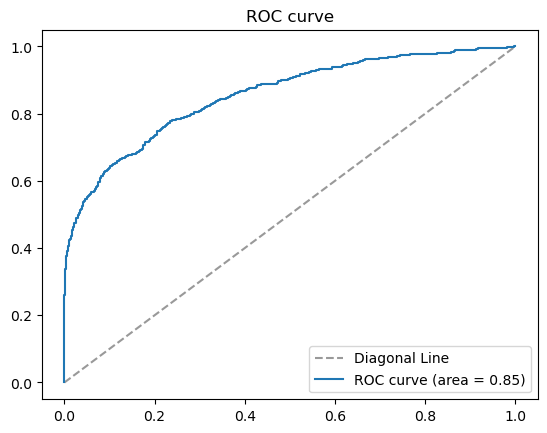

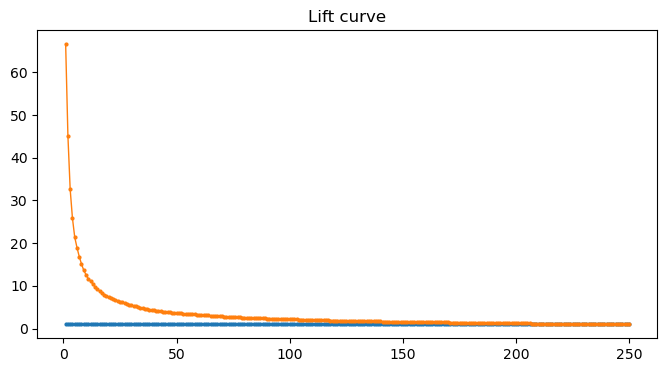

In [95]:
lgb_eval = model_eval(lgb_df, 'score', 'target', box_num=250, y_true=lgb_y_true, y_pred=lgb_y_pred, pos_prob_list=pos_prob_list_lgb)

In [96]:
lgb_eval

,precision,recall,accuracy,f1_score,KS_value,AUC,Gini,Lift
0,0.746725,0.322642,0.989176,0.450593,0.543953,0.854913,0.709827,66.550894


In [97]:
# Catboost分类器

cb1.fit(train_x, y_train, verbose=0)

In [98]:
# Catboost分类器（续）

cb_y_pred = cb1.predict(test_x)
cb_y_true = y_test

#获取所有x数据的坏客户预测概率
prob_list_cb = cb1.predict_proba(test_x)
pos_prob_list_cb = [i[1] for i in prob_list_cb]

cb_df = pd.DataFrame({'score': pos_prob_list_cb, 'target': y_test}) #合成一个数据集，内含预测概率，还有分类器给的值。用于计算ks, lift等指标。

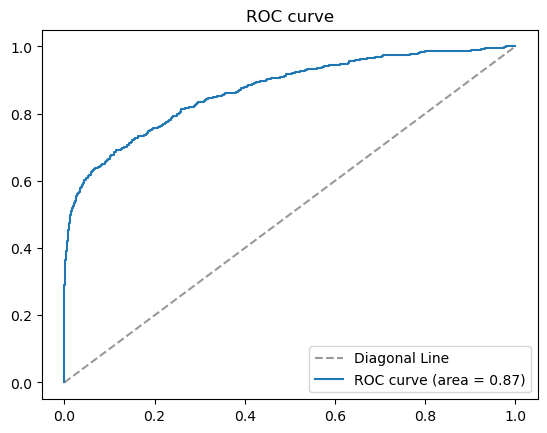

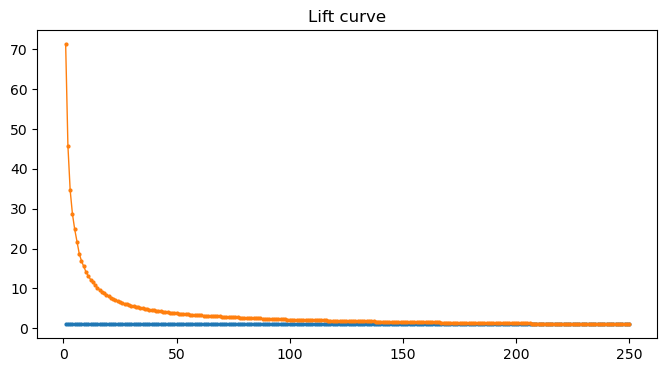

In [99]:
cb_eval = model_eval(cb_df, 'score', 'target', box_num=250, y_true=cb_y_true, y_pred=cb_y_pred, pos_prob_list=pos_prob_list_cb)

In [100]:
cb_eval

,precision,recall,accuracy,f1_score,KS_value,AUC,Gini,Lift
0,0.927273,0.288679,0.989902,0.440288,0.575592,0.869689,0.739378,71.270816


##### 依然无法解决查全率过低的问题。下面做个汇总

In [172]:
# 汇总四个模型的表现（后续会补充SVM分类、随机森林、神经网络）
eval_all = pd.concat([clf_eval, xgb_eval, lgb_eval, cb_eval], axis=0)
eval_all.reset_index(inplace=True)
eval_all.drop(columns=['index'], inplace=True)
eval_all.rename(index = {0:'Logistic_Regression', 1:'XGBoost_Classifier', 2:'LightGBM_Classifier', 3:'Catboost_Classifier'}, inplace=True)
eval_all

,precision,recall,accuracy,f1_score,KS_value,AUC,Gini,Lift
Logistic_Regression,0.928571,0.049057,0.986865,0.093190,0.500110,0.828401,0.656803,42.951286
XGBoost_Classifier,0.870270,0.303774,0.989799,0.450350,0.538101,0.850162,0.700325,68.438863
LightGBM_Classifier,0.746725,0.322642,0.989176,0.450593,0.543953,0.854913,0.709827,66.550894
Catboost_Classifier,0.927273,0.288679,0.989902,0.440288,0.575592,0.869689,0.739378,71.270816


##### 总体来看，模型表现是Catboost > xgb ≈ lgb > 逻辑回归。四个模型的查全率都较低，表明模型可能过于自信，将一些positive样本也预测为negative，导致查全率低下。

In [28]:
#交叉验证（先略过）
# from sklearn.model_selection import cross_val_score

### 第三部分：两种调参示例（以逻辑回归为例）

In [111]:
# 网格调参：GridSearchCV
# 待调参数：solver, penalty, C。max_iter暂定5000，防止无法收敛
# 注意：不是每一个solver都能适用全部的penalty term

param_grid = [
    {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.logspace(-4, 4, 10),
    'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga']
    }
]

In [115]:
# 网格调参具体语句。耗时太长，电脑吃不消了
# clf_grid = GridSearchCV(clf, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

# best_clf = clf_grid.fit(train_x, y_train)

In [ ]:
# 更快的调参方法：TuneSearchCV

# import tune_sklearn as tune

### 第四部分：SMOTE过采样方法

In [125]:
import imblearn
from imblearn.over_sampling import SMOTE

In [135]:
# 逻辑回归

sm = SMOTE(random_state=0)

Y = ldata['target']
X = ldata.iloc[:,:-1]

train_x, test_x, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [137]:
train_x_smote, y_train_smote = sm.fit_resample(train_x, y_train) # k_neighbors=5 in default

In [139]:
clf2 = LogisticRegression(max_iter=5000)

clf2.fit(train_x_smote, y_train_smote)

LogisticRegression(max_iter=5000)

In [140]:
clf2_y_pred = clf2.predict(test_x)
clf2_y_true = y_test

#获取所有x数据的坏客户预测概率
prob_list_clf2 = clf2.predict_proba(test_x)
pos_prob_list_clf2 = [i[1] for i in prob_list_clf2]

clf2_df = pd.DataFrame({'score': pos_prob_list_clf2, 'target': clf2_y_true})

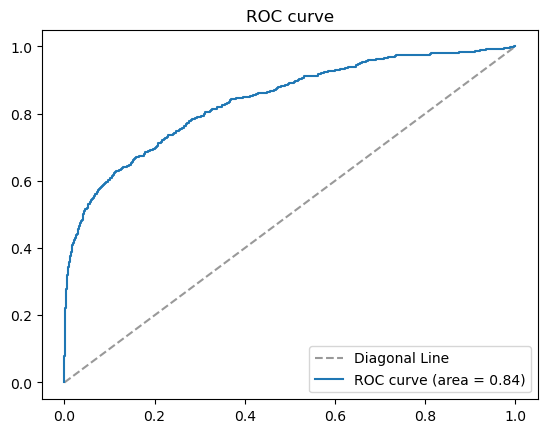

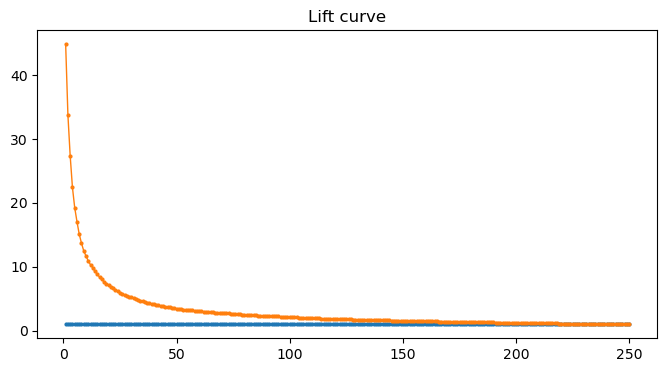

In [141]:
clf2_eval = model_eval(clf2_df, 'score', 'target', box_num=250, y_true=clf2_y_true, y_pred=clf2_y_pred, pos_prob_list=pos_prob_list_clf2)

In [142]:
eval_all = pd.concat([eval_all, clf2_eval], axis=0)
eval_all

,precision,recall,accuracy,f1_score,KS_value,AUC,Gini,Lift
Logistic_Regression,0.865854,0.133962,0.987800,0.232026,0.544650,0.845115,0.690230,49.559177
XGBoost_Classifier,0.870270,0.303774,0.989799,0.450350,0.538101,0.850162,0.700325,68.438863
LightGBM_Classifier,0.746725,0.322642,0.989176,0.450593,0.543953,0.854913,0.709827,66.550894
Catboost_Classifier,0.927273,0.288679,0.989902,0.440288,0.575592,0.869689,0.739378,71.270816
0,0.051389,0.673585,0.824447,0.095493,0.513915,0.838569,0.677138,44.839255


##### k_neighbor=5的模型过于保守了, 导致precision太低

In [145]:
# 对SMOTE的k_neighbors参数进行调参

precision_trail = []
recall_trail = []

for i in range(3, 30):

    sm_trail = SMOTE(random_state=0, k_neighbors=i)
    smote_x, smote_y = sm_trail.fit_resample(train_x, y_train) # 迭代k_neighbors

    clf_trail = LogisticRegression(max_iter=5000)
    clf_trail.fit(smote_x, smote_y)

    clf_trail_pred = clf_trail.predict(test_x)
    clf_trail_true = y_test

    precision_trail.append(precision_score(y_true=clf_trail_true, y_pred=clf_trail_pred))
    recall_trail.append(recall_score(y_true=clf_trail_true, y_pred=clf_trail_pred))

0.8250700861800436
0.8254594538469525
0.8244470979129893
0.8254075381580314
0.826783303914443
0.8257449901360191
0.8247585920465165
0.8258488215138615
0.8262901048696916
0.826523725469837
0.8255892430692555
0.8258747793583221
0.8264198940919946
0.8260824421140068
0.8250181704911225
0.8256930744470979
0.8265496833142976
0.8255892430692555
0.8260045685806251
0.826783303914443
0.8265756411587581
0.8262901048696916
0.8267313882255217
0.826783303914443
0.8270169245145883
0.8260564842695463
0.8259786107361645


In [147]:
recall_trail

[0.6792452830188679,
 0.6735849056603773,
 0.6735849056603773,
 0.6754716981132075,
 0.6735849056603773,
 0.6754716981132075,
 0.6773584905660377,
 0.6773584905660377,
 0.6773584905660377,
 0.6773584905660377,
 0.6754716981132075,
 0.6735849056603773,
 0.6698113207547169,
 0.6773584905660377,
 0.6754716981132075,
 0.6773584905660377,
 0.6773584905660377,
 0.6773584905660377,
 0.6773584905660377,
 0.6735849056603773,
 0.6754716981132075,
 0.6754716981132075,
 0.6773584905660377,
 0.6773584905660377,
 0.6735849056603773,
 0.6735849056603773,
 0.6773584905660377]

##### 效果很差，验证了SMOTE方法适用于决策树但不适用于逻辑回归的观点。

In [164]:
# 另一种尝试：带label_weight的逻辑回归

#设置权重
clf_w = {0: 1, 1: 73}
#定义模型
clfw = LogisticRegression(random_state=0, max_iter=5000, solver='newton-cg') # solver = 'newton-cholesky' for sklearn 1.2.0
#拟合
clfw.fit(train_x, y_train)
#预测
clfw_y_pred = clfw.predict(test_x)
clfw_y_true = y_test
#训练结果
print(f'accuracy_score: {accuracy_score(clfw_y_true, clfw_y_pred)}')
print(f'precision_score: {precision_score(clfw_y_true, clfw_y_pred)}')
print(f'recall_score: {recall_score(clfw_y_true, clfw_y_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(clfw_y_true, clfw_y_pred)}')


accuracy_score: 0.9877998131035198
precision_score: 0.8658536585365854
recall_score: 0.1339622641509434
Confusion Matrix: 
[[37983    11]
 [  459    71]]


In [40]:
# 保存模型

import pickle

In [42]:
#保存训练好的模型
save_classifier = open('catboost5.pickle', 'wb')
pickle.dump(cb1, save_classifier)
save_classifier.close()

In [43]:
classifier_f = open('catboost5.pickle', 'rb')
classifier = pickle.load(classifier_f)
classifier_f.close()

<font face="微软雅黑" size=3 color=#A52A2A > 数据降维（非PCA）与特征权重的计算

In [151]:
#数据清洗后的降维操作(以110个变量为例)
filename = 'data1.csv'
data_x = pd.read_csv(filename)
data_x

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_2ership,annual_inc,...,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,disbursement_method,debt_settlement_flag,target
0,10000,10000,10000.0,0,0.1033,324.23,1,0,0,280000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,2500,2500,2500.0,0,0.1356,84.92,2,10,1,55000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
2,12000,12000,12000.0,1,0.1356,276.49,2,0,0,40000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
3,15000,15000,14975.0,1,0.1447,352.69,2,11,0,30000.0,...,48.8,0.0,15.0,0.0,0.0,NaN,0,1,0,0
4,16000,16000,16000.0,1,0.1797,406.04,3,5,0,51000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128407,23000,23000,23000.0,0,0.1502,797.53,2,10,0,75000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1
128408,10000,10000,10000.0,0,0.1502,346.76,2,5,0,38000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
128409,5000,5000,5000.0,0,0.1356,169.83,2,10,0,35360.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
128410,10000,10000,9750.0,0,0.1106,327.68,1,11,1,44400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0


In [153]:
feature_importances = cb1.feature_importances_
names = data_x.columns
list_feature_importances = list(zip(feature_importances, names))
df_feature_importances = pd.DataFrame(list_feature_importances)
df_feature_importances.to_excel('catboost_110变量信息增益.xlsx')  #在excel中

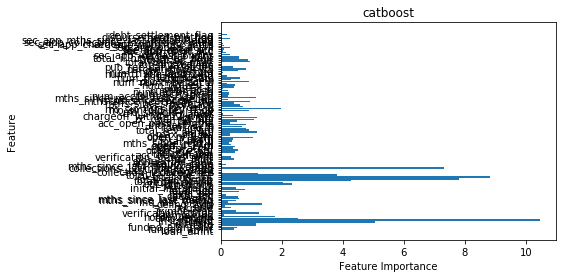

In [160]:
n_features=data_x.shape[1] - 1 #target列省略
plt.barh(range(n_features), feature_importances, align='center')
plt.yticks(np.arange(n_features), data_x.columns)
plt.title('catboost')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
#这个语句不跑，懒得再挑新变量
#cb.fit(train_x, y_train, cat_features = [9, 10, 11, 12，13]) 以第9个到第13个数值型变量为categorical variables
#上述语句适用于字符型变量。catboost接受nan，但不接受空值，所有空值都需用nan替换。在训练结果上，字符型作数值型处理的f1_score, AUC等指标较好。

<font face="微软雅黑" size=3 color=#A52A2A > GridSearchCV 网格调参模块

In [164]:
#调参

params = {'depth': [4, 7, 10],
        'learning_rate': [0.03, 0.1, 0.15],
        'l2_leaf_reg': [1, 4, 9],
        'iterations': [300]}
cb_model = GridSearchCV(cb1, params, scoring='roc_auc')

In [166]:
cb_model.score(test_x, y_test)

0.8655452052508787

In [167]:
cb_model.score(train_x, y_train)

0.9287579152658905

<font face="微软雅黑" size=3 color=#A52A2A > 控制ensemble tree的迭代树数量，树深度

In [170]:
#cb = cb.CatboostClassifier(iterations = 10000, depth = 4)

<font face="微软雅黑" size=3 color=#A52A2A > 防止过度拟合的另两种方法：控制学习率，L2正则化

In [171]:
#cb = cb.CatboostClassifier(learning_rate = 0.1)

#cb = cb.CatboostClassifier(l2_leaf_reg = 1)